In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
%matplotlib inline
from sklearn.model_selection import cross_val_score

In [104]:
events_data = pd.read_csv('event_data_train.csv')
submission_data = pd.read_csv('submissions_data_train.csv')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit = 's')
submission_data['day'] = submission_data.date.dt.date

users_data = events_data.groupby('user_id', as_index= False)\
        .agg({'timestamp': 'max'})\
        .rename({'timestamp':'last_timestamp'}, axis = 'columns')
now = 1526772811
drop_out_threasold = 2592000

users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threasold
users_scores = submission_data.pivot_table(index='user_id',\
                        columns = 'submission_status',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index()
users_data = users_data.merge(users_scores, on = 'user_id', how = 'outer')
users_data = users_data.fillna(0)
users_invent_data = events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values  = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).reset_index()
users_data = users_data.merge(users_invent_data, how = 'outer')
users_days = events_data.groupby('user_id').day.nunique()
users_days.to_frame().reset_index()
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')
users_data['passed_corse'] = users_data.passed > 170

In [105]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


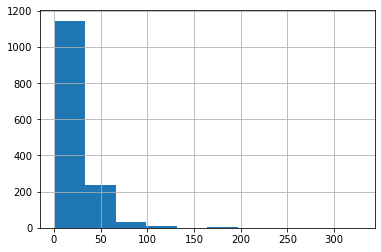

In [106]:
users_data[users_data.passed_corse].day.hist()

In [107]:
users_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp':'min'}) \
.rename({'timestamp':'min_timestamp'},axis=1)

In [108]:
users_data = users_data.merge(users_min_time, how='outer')

In [109]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [110]:
events_data = events_data.merge(users_min_time, how = 'outer')
events_data_3_days = events_data.query("timestamp <= min_timestamp + 3 * 24 * 60* 60")

In [111]:
events_data_3_days.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [112]:
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [113]:
last_tryes = submission_data.groupby(['user_id'], as_index=False).agg({'date':'max'}).rename(columns={'date':'max_date'})
last_tryes.head()

,user_id,max_date
0,2,2017-12-27 14:04:45
1,3,2015-10-11 14:28:48
2,5,2017-07-12 11:42:10
3,8,2016-12-01 14:55:43
4,14,2015-07-08 15:16:41


In [114]:
submission_data = submission_data.merge(last_tryes, how = 'outer')
submission_data.head()    

,step_id,timestamp,submission_status,user_id,date,day,max_date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,2016-11-21 13:16:03
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,2016-11-21 13:16:03
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,2016-11-21 13:16:03
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,2016-11-21 13:16:03
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,2016-11-21 13:16:03


In [115]:
max_submission_data = submission_data.query("date == max_date")  
max_submission_data 

,step_id,timestamp,submission_status,user_id,date,day,max_date
46,33025,1479734163,correct,15853,2016-11-21 13:16:03,2016-11-21,2016-11-21 13:16:03
133,31991,1436207389,correct,6640,2015-07-06 18:29:49,2015-07-06,2015-07-06 18:29:49
262,33669,1436338096,correct,8624,2015-07-08 06:48:16,2015-07-08,2015-07-08 06:48:16
629,33685,1435854481,correct,24821,2015-07-02 16:28:01,2015-07-02,2015-07-02 16:28:01
783,33669,1436806235,correct,16503,2015-07-13 16:50:35,2015-07-13,2015-07-13 16:50:35
...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,2017-08-05 15:29:19
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,2017-08-18 12:38:47
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,2017-09-25 14:02:33
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,2018-04-06 17:21:56


In [121]:
timestamp_count = max_submission_data.groupby(['step_id'], as_index=False) \
.agg({'user_id':'count'}).rename(columns={'user_id':'users_count'})
timestamp_count.head(20)

,step_id,users_count
0,31971,225
1,31972,215
2,31976,74
3,31977,293
4,31978,978
5,31979,240
6,31981,81
7,31983,106
8,31986,19
9,31988,21


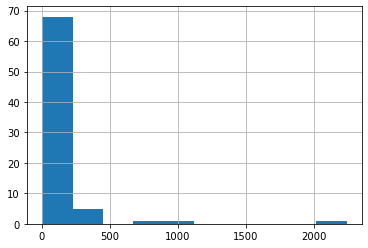

In [117]:
timestamp_count.users_count.hist()

отбираем сколько человек пытался сделать уникальных степов прежде чем уйти 

из данных про events узнаем сколько у нас было всего просмотренных степов 

отбираем пользователей которые еще не ушли но и курс еще не закончили с помощью passed_course и is_gone_user \
перевести bool в int:\
y = X.passed_course.map(int)
